Titanic 실습 <br>
https://www.kaggle.com/c/titanic/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_df = pd.read_csv('./titanic/train.csv')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 전처리

### 결측치 정리

In [69]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(),inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)


### 문자형 데이터 확인 

In [70]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [71]:
titanic_df.Sex.value_counts() ,titanic_df.Cabin.value_counts(), titanic_df.Embarked.value_counts(), titanic_df.Ticket.value_counts()


(male      577
 female    314
 Name: Sex, dtype: int64,
 N              687
 C23 C25 C27      4
 G6               4
 B96 B98          4
 C22 C26          3
               ... 
 E34              1
 C7               1
 C54              1
 E36              1
 C148             1
 Name: Cabin, Length: 148, dtype: int64,
 S    644
 C    168
 Q     77
 N      2
 Name: Embarked, dtype: int64,
 347082      7
 CA. 2343    7
 1601        7
 3101295     6
 CA 2144     6
            ..
 9234        1
 19988       1
 2693        1
 PC 17612    1
 370376      1
 Name: Ticket, Length: 681, dtype: int64)

In [72]:
# cabin은 등급 추출을 위해 첫자리만 추출
titanic_df.Cabin = titanic_df.Cabin.str[:1]
titanic_df.Cabin.value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

## EDA

머신러닝을 사용하여 예측을 수행하기 전에 데이터를 먼저 탐색해보자<br>
 우선 어떤 유형의 승객이 생존확률이 높았는지 확인, <br>
 타이타낙 영화에서도 여성, 아이들, 노약자가 먼저 구조대상, 이후 부자나 유명인 <br>
 삼등실에 탄 사람은 아마도 생존이 어렵지 않았을까

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

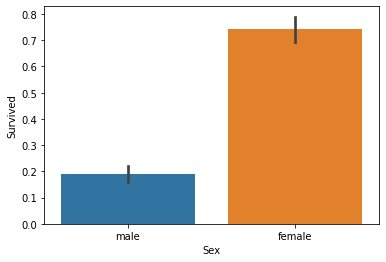

In [73]:
sns.barplot(x='Sex', y ='Survived', data = titanic_df)

여성의 생존율이 70% 이상으로 높았음

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

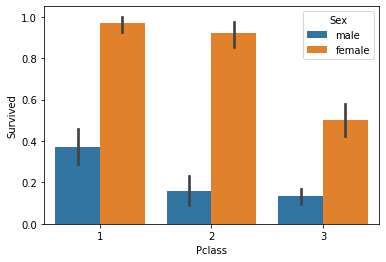

In [74]:
sns.barplot(x='Pclass',y='Survived', hue='Sex', data=titanic_df)

1>2>3등석으로 생존확율

이번엔 Age에 따른 생존확율을 구해보자.<br>
범주형으로 처리 필요

In [75]:
def get_category(age):
    
    if age <= -1 : cat = 'Unknown'
    elif age <=5 : cat = 'Baby'
    elif age <=12 : cat = 'Child'
    elif age <= 18 : cat = 'Teenager'
    elif age <= 25 : cat = 'Student'
    elif age <= 35 : cat = 'Young Adult'
    elif age <= 60 : cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

<AxesSubplot:xlabel='Age_cat', ylabel='Survived'>

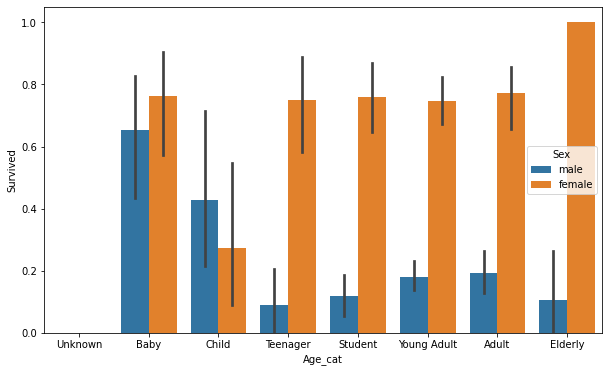

In [76]:
group_names = ['Unknown','Baby','Child','Teenager','Student','Young Adult','Adult','Elderly']
plt.figure(figsize=(10,6))

titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x= 'Age_cat', y = 'Survived', hue='Sex', data= titanic_df, order= group_names)

## 예측모델 생성

In [77]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

def encode_feature(dataDF):
    features = ['Sex','Cabin','Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit_transform(dataDF[feature])
        dataDF[feature] = le.fit_transform(dataDF[feature])
    
    return dataDF

titanic_df = encode_feature(titanic_df)
titanic_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3,Young Adult
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3,Young Adult


In [78]:
titanic_df.drop(['Name','PassengerId','Ticket','Age_cat'],axis =1, inplace= True)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,3
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,7,3
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,7,3


In [79]:
from sklearn.model_selection import GridSearchCV

X = titanic_df.drop('Survived', axis = 1)
y = titanic_df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

lg_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
dt_clf = DecisionTreeClassifier()


grid_parameters = {'max_depth' : [2,3,5,10],
                   'min_samples_split' : [2,3,5],
                   'min_samples_leaf':[1,5,8]
                  }

grid_dtree = GridSearchCV(dt_clf, param_grid=grid_parameters, refit=True)
grid_dtree.fit(X_train, y_train)
score_df = pd.DataFrame(grid_dtree.cv_results_)
score_df[['params','mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.786566,25,0.769231,0.769231,0.774648
1,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.786566,25,0.769231,0.769231,0.774648
2,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.786566,25,0.769231,0.769231,0.774648
3,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.786566,25,0.769231,0.769231,0.774648
4,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.786566,25,0.769231,0.769231,0.774648
5,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.786566,25,0.769231,0.769231,0.774648
6,"{'max_depth': 2, 'min_samples_leaf': 8, 'min_s...",0.786566,25,0.769231,0.769231,0.774648
7,"{'max_depth': 2, 'min_samples_leaf': 8, 'min_s...",0.786566,25,0.769231,0.769231,0.774648
8,"{'max_depth': 2, 'min_samples_leaf': 8, 'min_s...",0.786566,25,0.769231,0.769231,0.774648
9,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.813218,5,0.783217,0.832168,0.795775


In [80]:
grid_dtree.best_params_, grid_dtree.best_score_

({'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 5},
 0.8160149709445484)

In [81]:
best_dtree = grid_dtree.best_estimator_
y_pred = best_dtree.predict(X_test)
accuracy_score(y_test, y_pred)

0.7877094972067039

In [82]:
grid_rf = GridSearchCV(rf_clf, param_grid=grid_parameters, refit=True)
grid_rf.fit(X_train, y_train)
score_df = pd.DataFrame(grid_rf.cv_results_)
score_df[['params','mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.783778,32,0.762238,0.755245,0.781690
1,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.789333,30,0.790210,0.783217,0.816901
2,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.778144,35,0.755245,0.762238,0.760563
3,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.783749,33,0.776224,0.762238,0.781690
4,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.789353,29,0.783217,0.776224,0.774648
5,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.782360,34,0.748252,0.776224,0.788732
6,"{'max_depth': 2, 'min_samples_leaf': 8, 'min_s...",0.789422,27,0.762238,0.748252,0.788732
7,"{'max_depth': 2, 'min_samples_leaf': 8, 'min_s...",0.785147,31,0.797203,0.748252,0.788732
8,"{'max_depth': 2, 'min_samples_leaf': 8, 'min_s...",0.778125,36,0.790210,0.741259,0.767606
9,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.799183,21,0.783217,0.797203,0.809859


In [83]:
grid_rf.best_score_, grid_rf.best_params_

(0.823096621688171,
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3})

In [84]:
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8212290502793296

In [85]:
from sklearn.metrics import accuracy_score
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)
accuracy_score(np.array(y_test),y_pred)

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7653631284916201

In [88]:
confusion_matrix(y_test,y_pred)

array([[87, 19],
       [23, 50]])

In [90]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       106
           1       0.72      0.68      0.70        73

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.76      0.77      0.76       179

